In [1]:
import pandas as pd
import utils
import numpy as np
import plotly.express as px

In this notebook, we calculate the mean average precision to identify replicable perturbations and then for retrieving gene-compound pairs. The following are the steps taken.
1. Normalized, feature selected compound profiles for replicate plates are merged into a single data frame, separately for each time point and cell line.
2. Empty wells are removed from all the compound plates.
3. mAP is calculated for compound replicate retrieval (replicability). mAP for a random baseline is subtracted.
4. Negcon wells are removed from the compounds plates.
5. Median consensus profiles are created for all compounds.
6. Non-replicable perturbations are removed (mean AP ≤ 0)
7. Additional target annotations are added to the compound profiles.
8. mAP is calculated for compound-compound pair retrieval (those targeting the same gene). mAP for a random baseline is subtracted.
9. Steps 1 to 6 are repeated for each genetic perturbation, separately for each time point and cell line.
10. Step 8 is repeated for the CRISPR plates.
11. mAP is then calculated for the task of gene-compound pair retrieval. mAP for a random baseline is subtracted.
12. Tables of mAP values are printed and bar plots of mAP values are plotted.

In [2]:
replicability_df = pd.DataFrame()
matching_df = pd.DataFrame()
gene_compound_matching_df = pd.DataFrame()

feature_to_group_by = "Metadata_broad_sample"
batch = "2020_11_04_CPJUMP1"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query('Cell_type==@cell')
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query('Perturbation==@modality_1_perturbation')
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query('Time==@modality_1_timepoint')
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            # Read all the plates
            data_df = (
                utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                .assign(Metadata_modality=modality_1_perturbation)
            )
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        # Set Metadata_broad_sample value to "DMSO" for DMSO wells
        modality_1_df[feature_to_group_by].fillna("DMSO", inplace=True)

        # Remove empty wells
        modality_1_df = utils.remove_empty_wells(modality_1_df)

        # time
        time_1 = utils.time_point(modality_1_perturbation, modality_1_timepoint)

        # Calculate replicability mAP
        print(f'Computing {modality_1_perturbation}_{cell}_{time_1} replicablity')
        precision = utils.PrecisionScores(modality_1_df, modality_1_df, feature_to_group_by, within=True, challenge_negcon=True)

        replicability_df = replicability_df.append({'Description':f'{modality_1_perturbation}_{cell}_{time_1}',
                                                    'Modality':f'{modality_1_perturbation}',
                                                    'Cell':f'{cell}',
                                                    'time':f'{time_1}',
                                                    'timepoint': f'{modality_1_timepoint}',
                                                    'mAP':f'{precision.map:.3f}'}, ignore_index=True)

        # Remove DMSO wells
        modality_1_df = utils.remove_negcon_empty_wells(modality_1_df)

        # Create consensus profiles
        modality_1_consensus_df = utils.consensus(modality_1_df, feature_to_group_by)

        # Filter out non-replicable compounds
        compound_precision_df = precision.ap_group
        replicable_compounds = list(compound_precision_df.query("ap>0")[feature_to_group_by])
        modality_1_consensus_df = modality_1_consensus_df.query('Metadata_broad_sample==@replicable_compounds').reset_index(drop=True)

        # Adding additional gene annotation metadata
        modality_1_consensus_df = (
            modality_1_consensus_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
        )

        # Calculate compound-compound matching
        print(f'Computing {modality_1_perturbation}_{cell}_{time_1} matching')
        precision = utils.PrecisionScores(modality_1_consensus_df, modality_1_consensus_df, "Metadata_gene", within=True)

        matching_df = matching_df.append({'Description':f'{modality_1_perturbation}_{cell}_{time_1}',
                                          'Modality': f'{modality_1_perturbation}',
                                          'Cell': f'{cell}',
                                          'time':f'{time_1}',
                                          'timepoint':f'{modality_1_timepoint}',
                                          'mAP':f'{precision.map:.3f}'}, ignore_index=True)


        all_modality_2_experiments_df = cell_df.query('Perturbation!=@modality_1_perturbation')
        for modality_2_perturbation in all_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = all_modality_2_experiments_df.query('Perturbation==@modality_2_perturbation')
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query('Time==@modality_2_timepoint')
                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_target_list=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_2_df, data_df)

                # Remove empty wells
                modality_2_df = utils.remove_empty_wells(modality_2_df)

                # time
                time_2 = utils.time_point(modality_2_perturbation, modality_2_timepoint)

                description = f'{modality_2_perturbation}_{cell}_{time_2}'

                # Calculate replicability mAP
                print(f'Computing {modality_2_perturbation}_{cell}_{time_2} replicablity')
                precision = utils.PrecisionScores(modality_2_df, modality_2_df, feature_to_group_by, within=True, challenge_negcon=True)

                replicability_df = replicability_df.append({'Description':description,
                                                    'Modality':f'{modality_2_perturbation}',
                                                    'Cell':f'{cell}',
                                                    'timepoint': f'{modality_2_timepoint}',
                                                    'time':f'{time_2}',
                                                    'mAP':f'{precision.map:.3f}'}, ignore_index=True)

                # Remove negcon wells
                modality_2_df = utils.remove_negcon_empty_wells(modality_2_df)

                # Create consensus profiles
                modality_2_consensus_df = utils.consensus(modality_2_df, "Metadata_broad_sample")

                # Filter out non-replicable genes
                precision_df = precision.ap_group
                replicable_genes = list(precision_df.query("ap>0")[feature_to_group_by])
                modality_2_consensus_df = modality_2_consensus_df.query('Metadata_broad_sample==@replicable_genes').reset_index(drop=True)

                # Calculate cripsr-crispr matching
                if modality_2_perturbation == "crispr":
                    print(f'Computing {modality_2_perturbation}_{cell}_{time_2} matching')
                    precision = utils.PrecisionScores(modality_2_consensus_df, modality_2_consensus_df, "Metadata_gene", within=True)

                    matching_df = matching_df.append({'Description':description,
                                                      'Modality': f'{modality_2_perturbation}',
                                                      'Cell': f'{cell}',
                                                      'time':f'{time_2}',
                                                      'timepoint':f'{modality_2_timepoint}',
                                                      'mAP':f'{precision.map:.3f}'}, ignore_index=True)

                # Calculate gene-compound matching mAP
                print(f'Computing {modality_1_perturbation}_{cell}_{time_1}-{modality_2_perturbation}_{cell}_{time_2} matching')
                precision = utils.PrecisionScores(modality_1_consensus_df, modality_2_consensus_df, "Metadata_target_list", anti_correlation=True)

                gene_compound_matching_df = gene_compound_matching_df.append({'Description':f'{modality_1_perturbation}_{time_1} vs. {modality_2_perturbation}_{time_2}',
                                                                              'Modality1': f'{modality_1_perturbation}_{time_1}',
                                                                              'Modality2': f'{modality_2_perturbation}_{time_2}',
                                                                              'Cell': cell,
                                                                              'mAP':f'{precision.map:.3f}'}, ignore_index=True)


Computing compound_A549_short replicablity
Computing compound_A549_short matching
Computing crispr_A549_long replicablity
Computing crispr_A549_long matching
Computing compound_A549_short-crispr_A549_long matching
Computing crispr_A549_short replicablity
Computing crispr_A549_short matching
Computing compound_A549_short-crispr_A549_short matching
Computing orf_A549_long replicablity
Computing compound_A549_short-orf_A549_long matching
Computing orf_A549_short replicablity
Computing compound_A549_short-orf_A549_short matching
Computing compound_A549_long replicablity
Computing compound_A549_long matching
Computing crispr_A549_long replicablity
Computing crispr_A549_long matching
Computing compound_A549_long-crispr_A549_long matching
Computing crispr_A549_short replicablity
Computing crispr_A549_short matching
Computing compound_A549_long-crispr_A549_short matching
Computing orf_A549_long replicablity
Computing compound_A549_long-orf_A549_long matching
Computing orf_A549_short replicabli

In [4]:
# Remove duplicate entries
replicability_df.drop_duplicates(inplace=True)
matching_df.drop_duplicates(inplace=True)

Replicability mAP

In [5]:
print(replicability_df[['Description', 'timepoint', 'mAP']].to_markdown(index=False))

| Description         |   timepoint |   mAP |
|:--------------------|------------:|------:|
| compound_A549_short |          24 | 0.533 |
| crispr_A549_long    |         144 | 0.395 |
| crispr_A549_short   |          96 | 0.374 |
| orf_A549_long       |          96 | 0.148 |
| orf_A549_short      |          48 | 0.16  |
| compound_A549_long  |          48 | 0.704 |
| compound_U2OS_short |          24 | 0.55  |
| crispr_U2OS_long    |         144 | 0.255 |
| crispr_U2OS_short   |          96 | 0.333 |
| orf_U2OS_short      |          48 | 0.321 |
| orf_U2OS_long       |          96 | 0.214 |
| compound_U2OS_long  |          48 | 0.496 |


Within perturbation matching mAP

In [6]:
print(matching_df[['Description', 'timepoint', 'mAP']].to_markdown(index=False))

| Description         |   timepoint |   mAP |
|:--------------------|------------:|------:|
| compound_A549_short |          24 | 0.078 |
| crispr_A549_long    |         144 | 0.089 |
| crispr_A549_short   |          96 | 0.06  |
| compound_A549_long  |          48 | 0.074 |
| compound_U2OS_short |          24 | 0.065 |
| crispr_U2OS_long    |         144 | 0.076 |
| crispr_U2OS_short   |          96 | 0.067 |
| compound_U2OS_long  |          48 | 0.09  |


Gene-compound matching mAP

In [7]:
print(gene_compound_matching_df[['Description', 'Cell', 'mAP']].to_markdown(index=False))

| Description                     | Cell   |   mAP |
|:--------------------------------|:-------|------:|
| compound_short vs. crispr_long  | A549   | 0.001 |
| compound_short vs. crispr_short | A549   | 0.003 |
| compound_short vs. orf_long     | A549   | 0.01  |
| compound_short vs. orf_short    | A549   | 0.02  |
| compound_long vs. crispr_long   | A549   | 0.008 |
| compound_long vs. crispr_short  | A549   | 0.008 |
| compound_long vs. orf_long      | A549   | 0.008 |
| compound_long vs. orf_short     | A549   | 0.01  |
| compound_short vs. crispr_long  | U2OS   | 0.035 |
| compound_short vs. crispr_short | U2OS   | 0.027 |
| compound_short vs. orf_short    | U2OS   | 0.041 |
| compound_short vs. orf_long     | U2OS   | 0.05  |
| compound_long vs. crispr_long   | U2OS   | 0.006 |
| compound_long vs. crispr_short  | U2OS   | 0     |
| compound_long vs. orf_short     | U2OS   | 0.031 |
| compound_long vs. orf_long      | U2OS   | 0.018 |


In [8]:
replicability_df['mAP'] = replicability_df['mAP'].astype(float)
matching_df['mAP'] = matching_df['mAP'].astype(float)
gene_compound_matching_df['mAP'] = gene_compound_matching_df['mAP'].astype(float)

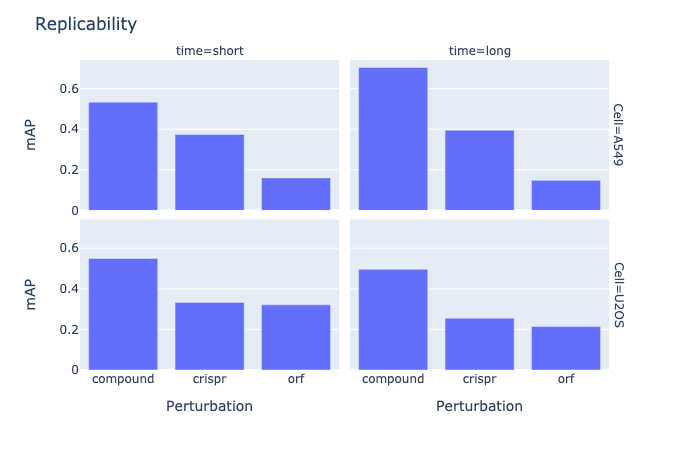

In [9]:
fig = px.bar(data_frame=replicability_df,
             x='Modality',
             y='mAP',
             facet_row='Cell',
             facet_col='time')
fig.update_layout(title='Replicability',
                  xaxis1=dict(title='Perturbation'),
                  xaxis2=dict(title='Perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/1.CellProfiler_replicability.png', width=640, height=480, scale=2)

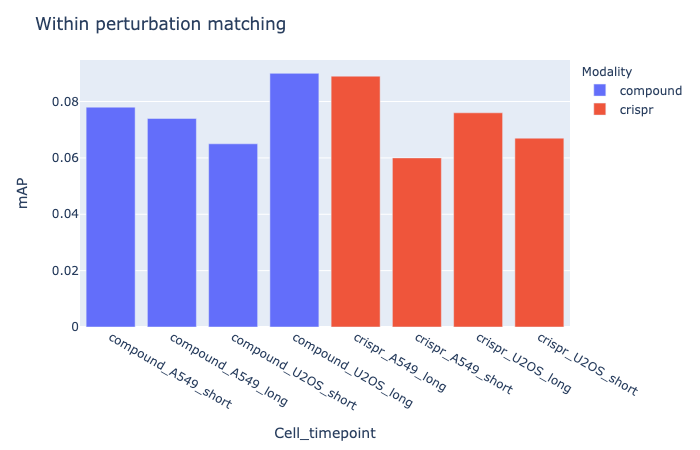

In [10]:
fig = px.bar(data_frame=matching_df,
             x='Description',
             y='mAP',
             color='Modality')
fig.update_layout(title='Within perturbation matching',
                  xaxis=dict(title='Cell_timepoint'),
                  yaxis=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/1.CellProfiler_matching.png', width=640, height=480, scale=2)

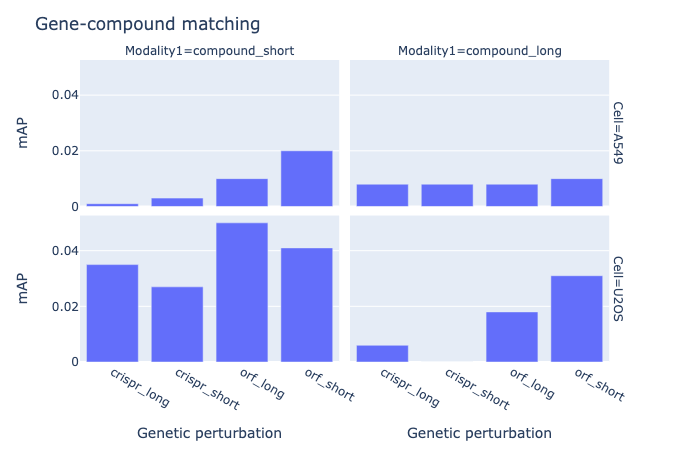

In [11]:
fig = px.bar(gene_compound_matching_df,
             x='Modality2',
             y='mAP',
             facet_col='Modality1',
             facet_row='Cell')
fig.update_layout(title='Gene-compound matching',
                  xaxis1=dict(title='Genetic perturbation'),
                  xaxis2=dict(title='Genetic perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/1.CellProfiler_gene_compound_matching.png', width=640, height=480, scale=2)

In [12]:
replicability_df[['Modality','Cell','time','mAP']].to_csv('output/cellprofiler_replicability.csv', index=False)
matching_df[['Modality', 'Cell', 'time', 'mAP']].to_csv('output/cellprofiler_matching.csv', index=False)
gene_compound_matching_df[['Modality1', 'Modality2', 'Cell', 'mAP']].to_csv('output/cellprofiler_gene_compound_matching.csv', index=False)